# Image Segmentation

In this notebook I started from the model seen in class and explored the hyperparameters space manually to find the direction in which the model could give better results.

In the end I found that the approach that resulted in a better performance was increasing the number of convolutional blocks (to 5) and starting filters (to 8) of the convolutional layers (only that model is uncommented).

Unfortunately I wasn't able to test more models because of the computational load of training these models.

The model building and training are encapsulated in functions.

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import json
from datetime import datetime
from PIL import Image

import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, UpSampling2D, ReLU

SEED = 1234
tf.random.set_seed(SEED)

cwd = os.getcwd()

## Dataset loading

In [3]:
bs = 8
img_w = 256
img_h = 256
validation_split = 0.1
dataset_dir = os.path.join(cwd, "Segmentation_Dataset")

# Image and masks data generators
image_data_gen = ImageDataGenerator(rotation_range = 10,
                                    width_shift_range = 10,
                                    height_shift_range = 10,
                                    zoom_range = 0.3,
                                    horizontal_flip = True,
                                    vertical_flip = True,
                                    fill_mode = 'constant',
                                    cval = 0,
                                    rescale = 1./255,
                                    validation_split = validation_split)
mask_data_gen = ImageDataGenerator(rotation_range = 10,
                                   width_shift_range = 10,
                                   height_shift_range = 10,
                                   zoom_range = 0.3,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   fill_mode = 'constant',
                                   cval = 0,
                                   rescale = 1./255,
                                   validation_split = validation_split)


train_dir = os.path.join(dataset_dir, "training")
train_img_dir = os.path.join(train_dir, "images")
train_mask_dir = os.path.join(train_dir, "masks")

# train generators
print("Training")
train_img_gen = image_data_gen.flow_from_directory(train_img_dir,
                                                   target_size = (img_h, img_w),
                                                   batch_size = bs,
                                                   class_mode = None,
                                                   shuffle = True,
                                                   interpolation = 'bilinear',
                                                   seed = SEED,
                                                   subset = 'training')
train_mask_gen = image_data_gen.flow_from_directory(train_mask_dir,
                                                   target_size = (img_h, img_w),
                                                   batch_size = bs,
                                                   class_mode = None,
                                                   shuffle = True,
                                                   interpolation = 'bilinear',
                                                   color_mode = 'grayscale',
                                                   seed = SEED,
                                                   subset = 'training')
train_gen = zip(train_img_gen, train_mask_gen)

# validation generators
print("\nValidation")
validation_img_gen = image_data_gen.flow_from_directory(train_img_dir,
                                                   target_size = (img_h, img_w),
                                                   batch_size = bs,
                                                   class_mode = None,
                                                   shuffle = True,
                                                   interpolation = 'bilinear',
                                                   seed = SEED,
                                                   subset = 'validation')
validation_mask_gen = image_data_gen.flow_from_directory(train_mask_dir,
                                                   target_size = (img_h, img_w),
                                                   batch_size = bs,
                                                   class_mode = None,
                                                   shuffle = True,
                                                   interpolation = 'bilinear',
                                                   color_mode = 'grayscale',
                                                   seed = SEED,
                                                   subset = 'validation')
validation_gen = zip(validation_img_gen, validation_mask_gen)

# datasets

def prepare_target(x_, y_):
    y_ = tf.cast(y_, tf.int32)
    return x_, y_

train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                              output_types = (tf.float32, tf.float32),
                                              output_shapes = ([None, img_h, img_w, 3], [None, img_h, img_w, 1]))
train_dataset = train_dataset.map(prepare_target)
train_dataset = train_dataset.repeat()

validation_dataset = tf.data.Dataset.from_generator(lambda: validation_gen,
                                              output_types = (tf.float32, tf.float32),
                                              output_shapes = ([None, img_h, img_w, 3], [None, img_h, img_w, 1]))
validation_dataset = validation_dataset.map(prepare_target)
validation_dataset = validation_dataset.repeat()

# write filenames to JSON file

filenames = {
    "training" : {},
    "validation" : {}
}

filenames["training"] = [fn.replace("img/","") for fn in train_img_gen.filenames]
filenames["validation"] = [fn.replace("img/","") for fn in validation_img_gen.filenames]

with open('dataset_split.json', 'w') as file:
    json.dump(filenames, file, indent=4)

print("\ndataset_split.json written\n")

# testing dataset

print("Testing")

test_dir = os.path.join(dataset_dir, "test", "images", "img")
test_filenames = next(os.walk(test_dir))[2]
test_filenames = list(filter(lambda fn: fn[-4:] == '.tif', test_filenames))

print("Found " + str(len(test_filenames)) + " images.")

Training
Found 6883 images belonging to 1 classes.
Found 6883 images belonging to 1 classes.

Validation
Found 764 images belonging to 1 classes.
Found 764 images belonging to 1 classes.

dataset_split.json written

Testing
Found 1234 images.


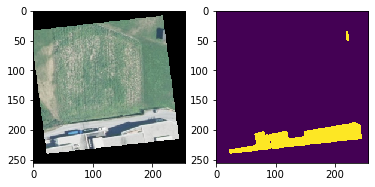

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2)

iterator = iter(train_dataset)
imgs, masks = next(iterator)

img = np.uint8(imgs[0].numpy()*255)
mask = np.uint8(masks[0].numpy()[:,:,0]*255)
    
ax[0].imshow(img)
ax[1].imshow(mask)

plt.show()

## Model building, fitting and predicting functions

In [5]:
def build_model(depth, start_num_filters, kernel_size, pool):
    """
    This function is used to build automatically the model given some hyperparameters.
    
    Parameters
    ----------
    depth: int
        the number of convolutional blocks used (convolution + activation + pooling).
    start_num_filters: int
        the number of convolutional filters used in the first convolutional layer, it's multiplied by two in every subsequent layer and divided by two in each upsampling block.
    kernel_size: pair of ints
        the size of the kernels of the convolutional layers.
    pool: int
        the pool size for the pooling layers (just one int, in pooling layers the pair is fed as (pool, pool).
        
    Returns
    -------
    model: Keras model
    """
    
    model = Sequential()
    
    # Encoder
    for i in range(depth):
        if i == 0:
            input_shape = [img_h, img_w, 3]
        else:
            input_shape = [None]
            
        # Convolution
        model.add(Conv2D(filters = start_num_filters,
                         kernel_size = kernel_size,
                         strides = (1, 1),
                         padding = 'same',
                         input_shape = input_shape))
        # Activation
        model.add(ReLU())
        # Pooling
        model.add(MaxPool2D(pool_size = (pool, pool)))
    
        start_num_filters *= 2
    
    start_num_filters //= 2
    
    # Decoder
    for i in range(depth):
        # Upsampling
        model.add(UpSampling2D(size = pool, interpolation = 'bilinear'))
        # Convolution
        model.add(Conv2D(filters = start_num_filters,
                         kernel_size = kernel_size,
                         strides = (1, 1),
                         padding = 'same'))
        # Activation
        model.add(ReLU())
        
        start_num_filters //= 2
    
    # Prediction
    model.add(Conv2D(filters = 1, 
                     kernel_size = (1, 1),
                     strides = (1, 1),
                     padding = 'same',
                     activation = 'sigmoid',))
    
    return model

In [6]:
def fit_model(model, model_name = datetime.now().strftime('%b%d_%H-%M-%S')):
    """
    Function used to fit the model (and save the checkpoints).
    It saves all the checkpoints that increased the performance and returns the best one.
    The performance evaluated is the loss.
    Early stopping is used with 10 epochs of patience.
    It also uses a tensorboard callback for visualization.
    
    Parameters
    ----------
    model: keras model
        model to fit.
    model_name: string, optional
        name of the model.
    
    Returns
    -------
    keras model: the best model.
    string: the directory of the model.
    """
    
    cwd = os.getcwd()
    
    # General experiments folder
    exps_dir = os.path.join(cwd, 'segmentation_experiments')
    if not os.path.exists(exps_dir):
        os.makedirs(exps_dir)
    
    now = datetime.now().strftime('%b%d_%H-%M-%S')
    
    # This experiment folder
    exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)
    
    # Checpoints folder
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)
    
    # Tensorboard folder
    tb_dir = os.path.join(exp_dir, 'tb_logs')
    if not os.path.exists(tb_dir):
        os.makedirs(tb_dir)
    
    # Checkpoints callback, best one will be the last saved
    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                       save_weights_only=True,
                                                       save_best_only=True)
    
    # Tensorboard callback
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                                 profile_batch=0,
                                                 histogram_freq=1)  # if 1 shows weights histograms
    
    # Early stopping callback
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    
    callbacks= [ckpt_callback, tb_callback, es_callback]
    
    model.fit(x=train_dataset,
              epochs=150,
              steps_per_epoch=len(train_img_gen),
              validation_data=validation_dataset,
              validation_steps=len(validation_img_gen), 
              callbacks=callbacks)
    
    # Load best model (last one saved)
    latest = tf.train.latest_checkpoint(ckpt_dir)
    print("Latest model: " + latest)
    model.load_weights(os.path.join(ckpt_dir, latest))
    
    return (model, exp_dir)

In [7]:
def create_csv(results, results_dir='./'):
    """
    Function used to write a prediction dictionary to a csv file
    
    Parameters
    ----------
    results: dict
        predictions
    results_dir: string, optional
        the directory
    """

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('ImageId,EncodedPixels,Width,Height\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + ',' + '256' + ',' + '256' + '\n')

In [8]:
def rle_encode(img):
    """
    Run Length Encoder
    """
    
    # Flatten column-wise
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [9]:
def predict(model, exp_dir):
    """
    Function used to make predictions and write them to file.
    
    Parameters
    ----------
    model: keras model
    exp_dir: the directory where the predictions must be saved.
    """
    
    results = {}

    for image_name in test_filenames:
        img = Image.open(os.path.join(test_dir,image_name)).convert('RGB').resize((img_w, img_h))
        img_array = np.array(img)
        img_array = np.expand_dims(img_array, 0)
        img_array = np.divide(img_array,255)
        tensor = tf.convert_to_tensor(img_array, dtype = tf.float32)
        
        prediction = model.predict(tensor)
        prediction = prediction[0,:,:,0]
        prediction = prediction >= 0.5
        prediction = prediction.astype(int)
        prediction = rle_encode(prediction)
        
        image_name = image_name[0:-4]
        results[image_name] = prediction
        
    create_csv(results = results, results_dir=exp_dir)

In [10]:
def my_IoU(y_true, y_pred):
    """
    Implementation of the IoU metric.
    """
    
    # from pobability to predicted class {0, 1}
    y_pred = tf.cast(y_pred > 0.5, tf.float32) # when using sigmoid. Use argmax for softmax

    # A and B
    intersection = tf.reduce_sum(y_true * y_pred)
    # A or B
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    # IoU
    return intersection / union

## Models

M_1: Base model (as seen in class)

In [ ]:
#name = 'M_1'
#
#lr = 1e-3
#optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
#loss = tf.keras.losses.BinaryCrossentropy()
#metrics = [my_IoU]
#
#
#model = build_model(depth = 4, 
#                    start_num_filters = 4, 
#                    kernel_size = (3,3), 
#                    pool = 2)
#
#model.compile(optimizer = optimizer,
#              loss = loss,
#              metrics = metrics)
#
#model.summary()
#
#model, m_dir = fit_model(model, name)
#
#predict(model, m_dir)

M_2: depth = 5

In [11]:
#name = 'M_2'
#
#lr = 1e-3
#optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
#loss = tf.keras.losses.BinaryCrossentropy()
#metrics = [my_IoU]
#
#
#model = build_model(depth = 5, 
#                    start_num_filters = 4, 
#                    kernel_size = (3,3), 
#                    pool = 2)
#
#model.compile(optimizer = optimizer,
#              loss = loss,
#              metrics = metrics)
#
#model.summary()
#
#model, m_dir = fit_model(model, name)
#
#predict(model, m_dir)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 4)       112       
_________________________________________________________________
re_lu (ReLU)                 (None, 256, 256, 4)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 4)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 8)       296       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        1

M_3: depth = 6

In [12]:
#name = 'M_3'
#
#lr = 1e-3
#optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
#loss = tf.keras.losses.BinaryCrossentropy()
#metrics = [my_IoU]
#
#
#model = build_model(depth = 6, 
#                    start_num_filters = 4, 
#                    kernel_size = (3,3), 
#                    pool = 2)
#
#model.compile(optimizer = optimizer,
#              loss = loss,
#              metrics = metrics)
#
#model.summary()
#
#model, m_dir = fit_model(model, name)
#
#predict(model, m_dir)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 256, 256, 4)       112       
_________________________________________________________________
re_lu_10 (ReLU)              (None, 256, 256, 4)       0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 4)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 128, 128, 8)       296       
_________________________________________________________________
re_lu_11 (ReLU)              (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 16)       

M_4: depth = 5, start_num_filters = 8

In [13]:
name = 'M_4'

lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
loss = tf.keras.losses.BinaryCrossentropy()
metrics = [my_IoU]


model = build_model(depth = 5, 
                    start_num_filters = 8, 
                    kernel_size = (3,3), 
                    pool = 2)

model.compile(optimizer = optimizer,
              loss = loss,
              metrics = metrics)

model.summary()

model, m_dir = fit_model(model, name)

predict(model, m_dir)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 256, 256, 8)       224       
_________________________________________________________________
re_lu_22 (ReLU)              (None, 256, 256, 8)       0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 128, 128, 16)      1168      
_________________________________________________________________
re_lu_23 (ReLU)              (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 64, 64, 32)       